In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from data_management.splits import DATA_POINTS_NAME
from data_management.get_counts import FileResult
from data_management.dataset_file import DatasetFile
from coqpyt.coq.structs import TermType
import json

In [2]:
analysis_loc = "/home/kthompson/coq-modeling/analysis/counts-20240115.json"

In [3]:
file_result = FileResult.load(analysis_loc)

In [4]:
DATA_POINTS_LOC = os.path.join("/data/benchmarks/coq-dataset", DATA_POINTS_NAME)

### Examples by Sentence Type

In [5]:
examples: dict[TermType, str] = {}
class Found(Exception):
    pass
for premise_key, count in file_result.avail_aggregator.table_counts.type_freqs.items():
    if premise_key.term_type in examples:
        continue
    try:
        for file_dir in os.listdir(DATA_POINTS_LOC):
            file_dir_loc = os.path.join(DATA_POINTS_LOC, file_dir)
            dset_file = DatasetFile.from_directory(file_dir_loc)
            for premise in dset_file.file_context.avail_premises:
                if premise.sentence_type == premise_key.term_type:
                    examples[premise_key.term_type] = premise.text
                    raise Found
    except Found:
        pass





KeyboardInterrupt: 

In [6]:
for example_type, example_str in examples.items():
    print(f"{example_type.name}: {example_str}")

DEFINITION: Definition not (A:Prop) := A -> False.
INDUCTIVE: Inductive True : Prop := I : True.
FACT: Fact nm_spec e D : e ⟼n @nm e D.
NOTATION: Notation "'if' c 'is' p 'then' u 'else' v" := (match c with p => u | _ => v end) (at level 200, p pattern at level 100).
FIXPOINT: Fixpoint nb_digits d := match d with | Nil => O | D0 d | D1 d | D2 d | D3 d | D4 d | D5 d | D6 d | D7 d | D8 d | D9 d | Da d | Db d | Dc d | Dd d | De d | Df d => S (nb_digits d) end.


### Available Premises

In [7]:
def plot_avg_premises(avg_results: dict[str, float],
                      ax_title: str) -> None:
    labels: list[str] = []
    avgs: list[float] = []
    for premise_type_name, avg in avg_results.items():
        print(f"  - {premise_type_name}: {avg}")
        formatted_avg = "{:.2f}".format(avg)
        label = f"{premise_type_name}: {formatted_avg}"
        labels.append(label)
        avgs.append(avg)
    fig, ax = plt.subplots()
    fig.suptitle(ax_title)
    #fig.set_title(ax_title)
    # https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    wedges, text = ax.pie(avgs)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
            bbox=bbox_props, zorder=0, va="center")

    avg_sum = sum(v for k, v in avg_results.items())
    for i, wedge in enumerate(wedges):
        ang_diff = wedge.theta2 - wedge.theta1
        ang = (ang_diff / 2.) + wedge.theta1
        piece_of_pie = avgs[i] / avg_sum
        if piece_of_pie < 0.01:
            continue 
        rad_ang = np.deg2rad(ang)
        x = np.cos(rad_ang)
        y = np.sin(rad_ang)
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw)
        

Average # of Premises Available by Type:
  - Origin: LOCAL_IN_FILE; Type: DEFINITION.: 9.877807431089225
  - Origin: LOCAL_IN_FILE; Type: INDUCTIVE.: 1.5441959384660613
  - Origin: LOCAL_IN_FILE; Type: FACT.: 0.8507279862441299
  - Origin: COQ_STD_LIB; Type: DEFINITION.: 996.0156223444081
  - Origin: COQ_STD_LIB; Type: NOTATION.: 692.5714626942457
  - Origin: COQ_STD_LIB; Type: FIXPOINT.: 179.1140953264646
  - Origin: COQ_STD_LIB; Type: THEOREM.: 459.4452028750953
  - Origin: COQ_STD_LIB; Type: INDUCTIVE.: 81.91171581409569
  - Origin: COQ_STD_LIB; Type: LEMMA.: 2157.5378794258586
  - Origin: COQ_STD_LIB; Type: TACTIC.: 246.37815627856557
  - Origin: LOCAL_OUT_OF_FILE; Type: NOTATION.: 15.262073006350708
  - Origin: COQ_STD_LIB; Type: VARIANT.: 7.2719249490509155
  - Origin: LOCAL_OUT_OF_FILE; Type: INDUCTIVE.: 4.797951216474788
  - Origin: LOCAL_OUT_OF_FILE; Type: FACT.: 2.7866201808903037
  - Origin: COQ_STD_LIB; Type: SCHEME.: 4.151903553752879
  - Origin: LOCAL_IN_FILE; Type: FIXPO

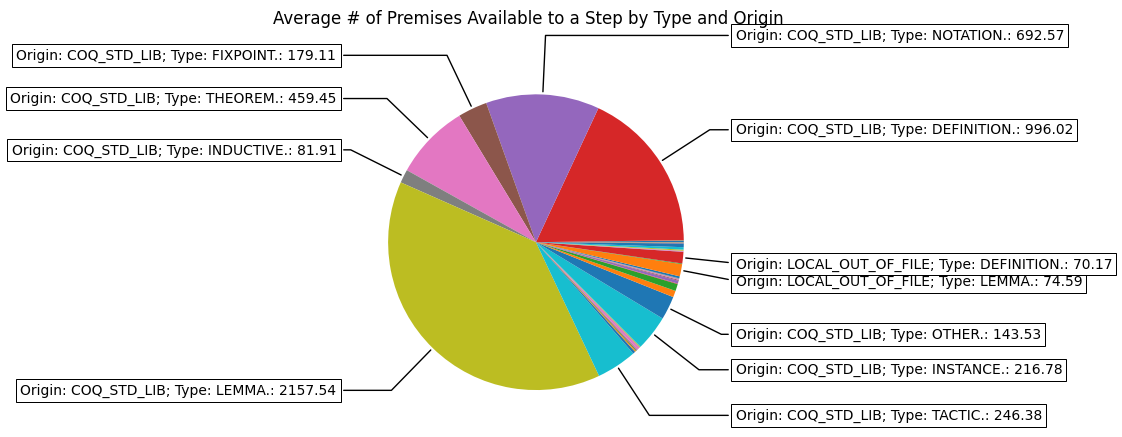

In [8]:
avg_file_results = file_result.avail_aggregator.compute_by_key()
print("Average # of Premises Available by Type:")
plot_avg_premises(avg_file_results, "Average # of Premises Available to a Step by Type and Origin")

In [9]:
entries: list[dict[str, float]] = []
for premise_key, count in file_result.avail_aggregator.table_counts.type_freqs.items():
    entries.append({"Origin": premise_key.origin.name,
                    "Type": premise_key.term_type.name,
                    "Count": count / file_result.avail_aggregator.num_tables})
df = pd.DataFrame(entries)


In [10]:
stacked = df.set_index(["Type", "Origin"]).unstack()
stacked[("Count", "TOTAL")] = stacked[("Count", "COQ_STD_LIB")] + stacked[("Count", "LOCAL")]
stacked.sort_values(("Count", "TOTAL"), ascending=False)

KeyError: ('Count', 'LOCAL')

### Positive Premises

Step Needs Premise Freq: 0.34167466494575216
Steps w/ pos prem & period: 0.0652616224426115
Steps w/ pos prem term type freqs:
{
  "Origin: COQ_STD_LIB; Type: NOTATION.": 0.1989533598502222,
  "Origin: LOCAL_IN_FILE; Type: INDUCTIVE.": 0.04587020759866764,
  "Origin: LOCAL_OUT_OF_FILE; Type: NOTATION.": 0.03168642901719588,
  "Origin: COQ_STD_LIB; Type: INDUCTIVE.": 0.09629841274615217,
  "Origin: LOCAL_IN_FILE; Type: DEFINITION.": 0.10574373858056949,
  "Origin: COQ_STD_LIB; Type: DEFINITION.": 0.09310285194402881,
  "Origin: LOCAL_OUT_OF_FILE; Type: FACT.": 0.0019128251013180747,
  "Origin: LOCAL_IN_FILE; Type: FACT.": 0.0068753430528508165,
  "Origin: COQ_STD_LIB; Type: LEMMA.": 0.09626081791318601,
  "Origin: COQ_STD_LIB; Type: CLASS.": 0.08525004323405791,
  "Origin: COQ_STD_LIB; Type: OTHER.": 0.14099716534959436,
  "Origin: LOCAL_IN_FILE; Type: THEOREM.": 0.04327466033068415,
  "Origin: LOCAL_OUT_OF_FILE; Type: DEFINITION.": 0.05306585862839011,
  "Origin: LOCAL_OUT_OF_FILE; Typ

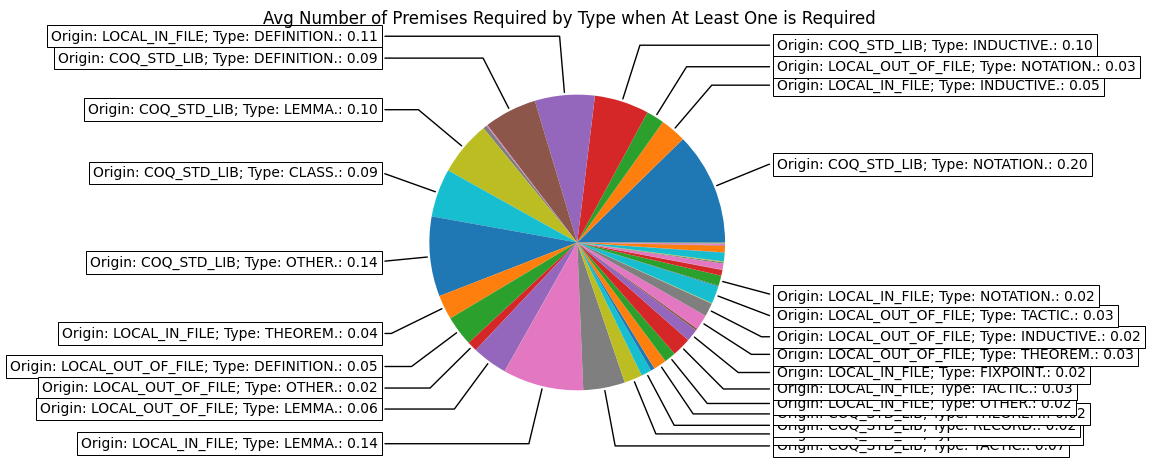

In [11]:
print(file_result.pos_aggregator)
pos_premise_avgs = file_result.pos_aggregator.compute_by_key()
plot_avg_premises(pos_premise_avgs,
                  "Avg Number of Premises Required by Type when At Least One is Required")


In [ ]:
entries: list[dict[str, float]] = []
for premise_key, count in file_result.pos_aggregator.table_counts.type_freqs.items():
    entries.append({"Origin": premise_key.origin.name,
                    "Type": premise_key.term_type.name,
                    "Count": count / file_result.pos_aggregator.num_nonempty_premises})
df = pd.DataFrame(entries)

In [ ]:
stacked = df.set_index(["Type", "Origin"]).unstack()
stacked[("Count", "TOTAL")] = stacked[("Count", "COQ_STD_LIB")] + stacked[("Count", "LOCAL")]
stacked.sort_values(("Count", "TOTAL"), ascending=False)

KeyError: ('Count', 'LOCAL')

In [ ]:
sum(file_result.pos_aggregator.table_counts.type_freqs.values())

1074042

In [ ]:
sum(file_result.avail_aggregator.table_counts.type_freqs.values()) / file_result.num_steps

5649.298339577814